In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from collections import Counter
from sklearn.metrics import roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

In [5]:
cd ..

/Users/kaancaylan/Desktop/HEC/Algorithmic Fairness and Explainability/interpretability_fairness_project


In [6]:
pd.set_option("display.max_columns", None)

In [7]:
dataset = pd.read_csv("data/train.csv", index_col=0)

In [5]:
dataset

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,1,0,1,0,1,1,38.172746,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
2,0,0,0,0,0,0,0,0,0,0,47.750517,m,?,no,no,India,no,2.255185,18 and more,Self,0
3,1,1,1,1,1,1,1,1,1,1,7.380373,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
4,0,0,0,0,0,0,0,0,0,0,23.561927,f,?,no,no,United States,no,2.276617,18 and more,Self,0
5,0,0,0,0,0,0,0,0,0,0,43.205790,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0,1,0,0,0,0,0,0,1,1,16.597187,m,Hispanic,no,no,New Zealand,no,12.999501,18 and more,Self,0
797,0,1,1,0,0,1,0,1,1,1,20.703001,m,White-European,no,no,Cyprus,no,13.561518,18 and more,Self,0
798,0,0,0,0,0,0,0,0,0,0,5.711481,m,South Asian,yes,no,New Zealand,no,2.653177,18 and more,Self,0


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 800
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         800 non-null    int64  
 1   A2_Score         800 non-null    int64  
 2   A3_Score         800 non-null    int64  
 3   A4_Score         800 non-null    int64  
 4   A5_Score         800 non-null    int64  
 5   A6_Score         800 non-null    int64  
 6   A7_Score         800 non-null    int64  
 7   A8_Score         800 non-null    int64  
 8   A9_Score         800 non-null    int64  
 9   A10_Score        800 non-null    int64  
 10  age              800 non-null    float64
 11  gender           800 non-null    object 
 12  ethnicity        800 non-null    object 
 13  jaundice         800 non-null    object 
 14  austim           800 non-null    object 
 15  contry_of_res    800 non-null    object 
 16  used_app_before  800 non-null    object 
 17  result          

In [7]:
Counter(dataset["Class/ASD"])

Counter({0: 639, 1: 161})

In [18]:
dataset.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

## Missing Values

In [19]:
df_raw = pd.read_csv("data/train.csv")
df_raw["ethnicity"].value_counts()

White-European     257
?                  203
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Turkish              5
others               3
Name: ethnicity, dtype: int64

In [22]:
(df_raw == "?").sum()

ID                   0
A1_Score             0
A2_Score             0
A3_Score             0
A4_Score             0
A5_Score             0
A6_Score             0
A7_Score             0
A8_Score             0
A9_Score             0
A10_Score            0
age                  0
gender               0
ethnicity          203
jaundice             0
austim               0
contry_of_res        0
used_app_before      0
result               0
age_desc             0
relation            40
Class/ASD            0
dtype: int64

In [25]:
df_raw["age_desc"].value_counts()

18 and more    800
Name: age_desc, dtype: int64

# Replace Infrequent Values

In [21]:
dataset["ethnicity"].str.lower().str.strip()

ID
1                   ?
2                   ?
3      white-european
4                   ?
5                   ?
            ...      
796          hispanic
797    white-european
798       south asian
799                 ?
800                 ?
Name: ethnicity, Length: 800, dtype: object

In [8]:
dataset.select_dtypes(include="object")

,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,age_desc,relation
ID,,,,,,,,
1,f,?,no,no,Austria,no,18 and more,Self
2,m,?,no,no,India,no,18 and more,Self
3,m,White-European,no,yes,United States,no,18 and more,Self
4,f,?,no,no,United States,no,18 and more,Self
5,m,?,no,no,South Africa,no,18 and more,Self
...,...,...,...,...,...,...,...,...
796,m,Hispanic,no,no,New Zealand,no,18 and more,Self
797,m,White-European,no,no,Cyprus,no,18 and more,Self
798,m,South Asian,yes,no,New Zealand,no,18 and more,Self


In [22]:
dataset["contry_of_res"].value_counts()

contry_of_res
United States           134
India                   108
New Zealand              78
United Kingdom           67
Jordan                   55
United Arab Emirates     40
Australia                37
Canada                   30
Afghanistan              22
Netherlands              20
Austria                  18
Sri Lanka                17
Brazil                   12
Spain                    10
France                   10
Kazakhstan               10
Ireland                   9
Iran                      8
Russia                    7
South Africa              6
Italy                     6
Bahamas                   6
Malaysia                  6
Viet Nam                  5
Pakistan                  4
China                     4
Mexico                    4
Nicaragua                 4
Armenia                   4
Azerbaijan                4
Iraq                      4
Aruba                     4
Saudi Arabia              4
AmericanSamoa             4
Bolivia                   3
Serbia

In [14]:
def replace_infreq_vals(df, columns, threshold=10):
    for colname in columns:
        category_counts = df[colname].value_counts()
        infrequent_categories = category_counts[category_counts < threshold].index
        df[colname] = df[colname].apply(lambda x: 'other' if x in infrequent_categories else x)
    return df


Index(['Latino', 'Hispanic', 'Turkish', 'others'], dtype='object', name='ethnicity')

# Label encoding

In [279]:
cat = dataset.select_dtypes(['object']).columns 
encoding_dict = dict()
for c in cat:
    encoder = LabelEncoder()
    dataset[c] = encoder.fit_transform(dataset[c])


# Histogram

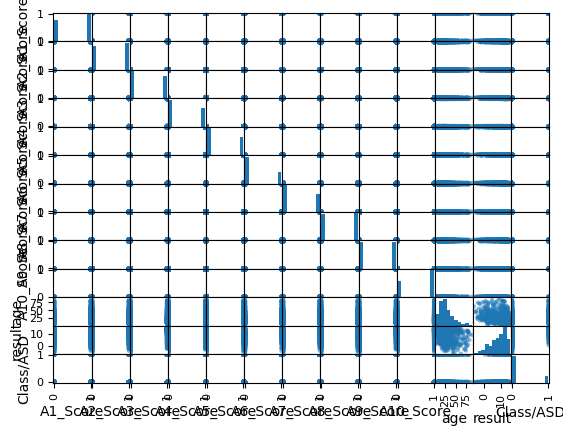

In [10]:
from pandas.plotting import scatter_matrix
scatter_matrix(dataset);

In [12]:
dataset.filter(regex="_Score").apply(lambda x:x.value_counts())

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
0,352,376,440,468,484,557,482,393,404,306
1,448,424,360,332,316,243,318,407,396,494


In [14]:
dataset.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

In [16]:
dataset["contry_of_res"].value_counts()

United States           134
India                   108
New Zealand              78
United Kingdom           67
Jordan                   55
United Arab Emirates     40
Australia                37
Canada                   30
Afghanistan              22
Netherlands              20
Austria                  18
Sri Lanka                17
Brazil                   12
Spain                    10
France                   10
Kazakhstan               10
Ireland                   9
Iran                      8
Russia                    7
South Africa              6
Italy                     6
Bahamas                   6
Malaysia                  6
Viet Nam                  5
Pakistan                  4
China                     4
Mexico                    4
Nicaragua                 4
Armenia                   4
Azerbaijan                4
Iraq                      4
Aruba                     4
Saudi Arabia              4
AmericanSamoa             4
Bolivia                   3
Serbia              

# Correlation

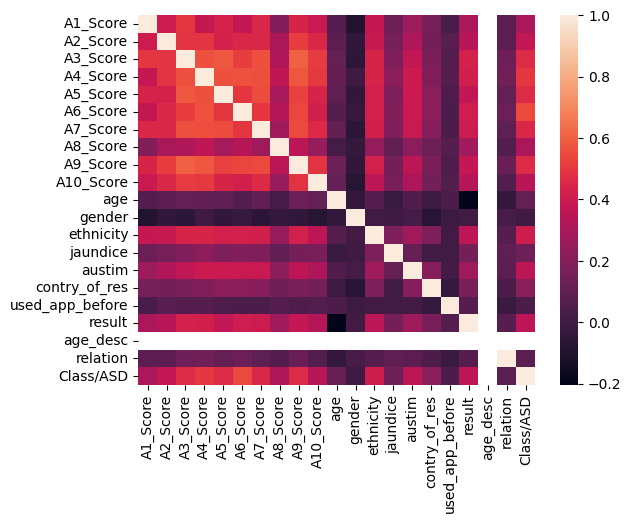

In [280]:
sns.heatmap(dataset.corr());

# Preprocessing

In [281]:
df = dataset.drop(["age_desc"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 1 to 800
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         800 non-null    int64  
 1   A2_Score         800 non-null    int64  
 2   A3_Score         800 non-null    int64  
 3   A4_Score         800 non-null    int64  
 4   A5_Score         800 non-null    int64  
 5   A6_Score         800 non-null    int64  
 6   A7_Score         800 non-null    int64  
 7   A8_Score         800 non-null    int64  
 8   A9_Score         800 non-null    int64  
 9   A10_Score        800 non-null    int64  
 10  age              800 non-null    float64
 11  gender           800 non-null    int32  
 12  ethnicity        800 non-null    int32  
 13  jaundice         800 non-null    int32  
 14  austim           800 non-null    int32  
 15  contry_of_res    800 non-null    int32  
 16  used_app_before  800 non-null    int32  
 17  result           800 

In [282]:
# cat_var = ['sex', 'Married', 'Number_children', 'education_level',
#             'total_members', 'incoming_salary', 'incoming_own_farm',
#             'incoming_business', 'incoming_no_business', 'labor_primary',
#             'depressed']
# for col in cat_var:
#     df[col] = df[col].astype('category')
# df.info()

In [283]:
continuous_var = df.select_dtypes(['int64']).columns

scaler = MinMaxScaler()
df[continuous_var] = scaler.fit_transform(df[continuous_var])

# Modelling

In [298]:
df = df.dropna()
X = df.drop("Class/ASD", axis=1)
y = df["Class/ASD"]

### Oversampling

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
smote = SMOTE(random_state=42)  # You can set a random seed for reproducibility
X_train, y_train = smote.fit_resample(X, y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Undersampling

In [287]:
# X_train["depressed"] = y_train
# train1 = X_train[X_train["depressed"]==1]
# train0 = X_train[X_train["depressed"]==0].sample(len(train1))
# train = pd.concat([train1, train0])
# X_train = train.drop("depressed", axis=1)
# y_train = train["depressed"]

In [326]:
model = XGBClassifier( tree_method="hist", device="cuda",
                       objective="binary:logistic",
                         eval_metric="auc"
                         )
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [327]:
y_pred = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)
auc_score

1.0

In [328]:
from sklearn.model_selection import cross_val_score
#clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring="roc_auc")
print(scores, scores.mean())
y_pred

[0.83984375 0.89526367 0.91772461 0.87573242 0.91935099] 0.8895830886684264


array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0])

In [329]:
confusion_matrix(y_pred, y_test)

array([[127,   0],
       [  0,  33]], dtype=int64)

In [347]:
importance = list()
for i, l in zip(X_train.columns, model.feature_importances_):
    importance.append([i, float(l)])
    print(i, l)

A1_Score 0.014050829
A2_Score 0.018696796
A3_Score 0.058028355
A4_Score 0.12950502
A5_Score 0.08567549
A6_Score 0.40223935
A7_Score 0.028293686
A8_Score 0.03292552
A9_Score 0.10617435
A10_Score 0.019745318
age 0.011153995
gender 0.008559208
ethnicity 0.013870986
jaundice 0.013669549
austim 0.0119075505
contry_of_res 0.01090513
used_app_before 0.0
result 0.009055509
relation 0.02554331


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'A1_Score'),
  Text(1, 0, 'A2_Score'),
  Text(2, 0, 'A3_Score'),
  Text(3, 0, 'A4_Score'),
  Text(4, 0, 'A5_Score'),
  Text(5, 0, 'A6_Score'),
  Text(6, 0, 'A7_Score'),
  Text(7, 0, 'A8_Score'),
  Text(8, 0, 'A9_Score'),
  Text(9, 0, 'A10_Score'),
  Text(10, 0, 'age'),
  Text(11, 0, 'gender'),
  Text(12, 0, 'ethnicity'),
  Text(13, 0, 'jaundice'),
  Text(14, 0, 'austim'),
  Text(15, 0, 'contry_of_res'),
  Text(16, 0, 'used_app_before'),
  Text(17, 0, 'result'),
  Text(18, 0, 'relation')])

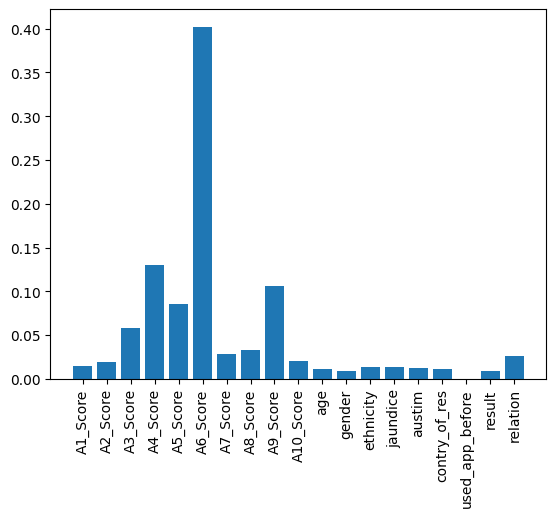

In [351]:
import matplotlib.pyplot as plt
plt.bar(X_train.columns, model.feature_importances_)
plt.xticks(rotation=90)

In [345]:
skf = StratifiedKFold(n_splits=2)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

'0.014050829224288464'